## Dataloader

In [1]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def create_train_val_test_dataloaders(data_dir, batch_size, num_workers=4):
    # Define specific transformations for each dataset
    data_transforms = {
        'train': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
        'test': transforms.Compose([
            transforms.Resize((244, 244)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ]),
    }

    # Create datasets using specific transformations
    image_datasets = {
        'train': datasets.ImageFolder(os.path.join(data_dir, 'train'), data_transforms['train']),
        'test': datasets.ImageFolder(os.path.join(data_dir, 'test'), data_transforms['test'])
    }

    # Create dataloaders
    dataloaders = {
        'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=num_workers),
        'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=num_workers)
    }
    return dataloaders

data_dir = 'Dataset/'
batch_size = 32
dataloaders = create_train_val_test_dataloaders(data_dir, batch_size)

In [14]:
import torch
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

## Load Models

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

def initialize_densenet(num_classes):
    model = models.densenet121(weights='DenseNet121_Weights.DEFAULT')
    num_ftrs = model.classifier.in_features
    model.classifier = nn.Linear(num_ftrs, num_classes)
    return model

## Training

In [4]:
from tqdm import tqdm
import torch
import os

def train_model(model, dataloaders, criterion, optimizer, num_epochs, save_dir):
    # Create directory for saving models if it doesn't exist
    os.makedirs(save_dir, exist_ok=True)

    train_loader = dataloaders['train']
    test_loader = dataloaders['test']

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Training'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            running_train_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct_train += (predicted == labels.float()).sum().item()
            total_train += labels.size(0)

        train_loss = running_train_loss / len(train_loader.dataset)
        train_acc = correct_train / total_train

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in tqdm(test_loader, desc=f'Epoch {epoch+1}/{num_epochs} - Validation'):
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs).squeeze()
                loss = criterion(outputs, labels.float())

                running_val_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                predicted = torch.round(torch.sigmoid(outputs))
                correct_val += (predicted == labels.float()).sum().item()
                total_val += labels.size(0)

        val_loss = running_val_loss / len(test_loader.dataset)
        val_acc = correct_val / total_val

        # Print epoch statistics
        print(f'Epoch [{epoch+1}/{num_epochs}] - '
              f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc*100:.2f}%')

        # Save the model after each epoch
        torch.save(model.state_dict(), os.path.join(save_dir, f'model_epoch_{epoch+1}.pth'))

    print('Training complete.')

## DenseNet

In [5]:
model = initialize_densenet(num_classes=1).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
train_model(model, dataloaders, criterion, optimizer, num_epochs=10, save_dir='Checkpoints/denseNet')

Epoch 1/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:54<00:00, 11.55it/s]


Epoch [1/10] - Train Loss: 0.1241, Train Acc: 95.31%, Val Loss: 0.0748, Val Acc: 97.32%


Epoch 2/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [00:54<00:00, 11.57it/s]


Epoch [2/10] - Train Loss: 0.0728, Train Acc: 97.30%, Val Loss: 0.0625, Val Acc: 97.65%


Epoch 3/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:10<00:00,  8.93it/s]


Epoch [3/10] - Train Loss: 0.0515, Train Acc: 98.05%, Val Loss: 0.0591, Val Acc: 97.81%


Epoch 4/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:11<00:00,  8.76it/s]


Epoch [4/10] - Train Loss: 0.0401, Train Acc: 98.50%, Val Loss: 0.0617, Val Acc: 97.78%


Epoch 5/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:10<00:00,  8.88it/s]


Epoch [5/10] - Train Loss: 0.0326, Train Acc: 98.80%, Val Loss: 0.0682, Val Acc: 97.59%


Epoch 6/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:10<00:00,  8.84it/s]


Epoch [6/10] - Train Loss: 0.0268, Train Acc: 99.01%, Val Loss: 0.0536, Val Acc: 98.22%


Epoch 7/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:15<00:00,  8.32it/s]


Epoch [7/10] - Train Loss: 0.0236, Train Acc: 99.14%, Val Loss: 0.0610, Val Acc: 98.02%


Epoch 8/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:11<00:00,  8.73it/s]


Epoch [8/10] - Train Loss: 0.0206, Train Acc: 99.28%, Val Loss: 0.0569, Val Acc: 98.19%


Epoch 9/10 - Validation: 100%|███████████████████████████████████████████████████████| 625/625 [01:11<00:00,  8.79it/s]


Epoch [9/10] - Train Loss: 0.0181, Train Acc: 99.34%, Val Loss: 0.0591, Val Acc: 97.87%


Epoch 10/10 - Validation: 100%|██████████████████████████████████████████████████████| 625/625 [01:10<00:00,  8.85it/s]

Epoch [10/10] - Train Loss: 0.0164, Train Acc: 99.39%, Val Loss: 0.0611, Val Acc: 98.04%
Training complete.


## Evaluation Metrices

In [15]:
# code to save the figures as high-res PNGs
import os
from pathlib import Path
from matplotlib import pyplot as plt

IMAGES_PATH = Path() / "Images/DenseNet"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

In [23]:
from torch import nn
from torchvision import models
from tqdm import tqdm

# Function to load the model with checkpoint
def load_model(checkpoint_path, num_classes, device):
    model = initialize_densenet(num_classes)
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.to(device)
    model.eval() 
    return model

In [17]:
import torch
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt

def evaluate_model(model_name, model, test_loader, criterion):
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Testing'):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs).squeeze()
            loss = criterion(outputs, labels.float())

            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            predicted = torch.round(torch.sigmoid(outputs))
            correct += (predicted == labels.float()).sum().item()
            total += labels.size(0)

            # Collect all labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    test_acc = correct / total

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc*100:.2f}%')

    # Generate classification report and confusion matrix
    print("\nClassification Report:")
    print(classification_report(all_labels, all_predictions, target_names=['FAKE', 'REAL']))

    print("\nConfusion Matrix:")
    skplt.metrics.plot_confusion_matrix(all_labels, all_predictions)
    save_fig(f"{model_name}_CM")

In [24]:
# List of model loading functions
model_functions = [
    initialize_densenet
]

checkpoint_paths = [
    'Checkpoints/denseNet/model_epoch_6.pth'
]

model_names = [
    'denseNet'
]

Checkpoints/denseNet/model_epoch_6.pth


Testing: 100%|███████████████████████████████████████████████████████████████████████| 625/625 [01:13<00:00,  8.49it/s]


Test Loss: 0.0536, Test Accuracy: 98.22%

Classification Report:
              precision    recall  f1-score   support

        FAKE       0.98      0.99      0.98     10000
        REAL       0.99      0.98      0.98     10000

    accuracy                           0.98     20000
   macro avg       0.98      0.98      0.98     20000
weighted avg       0.98      0.98      0.98     20000


Confusion Matrix:


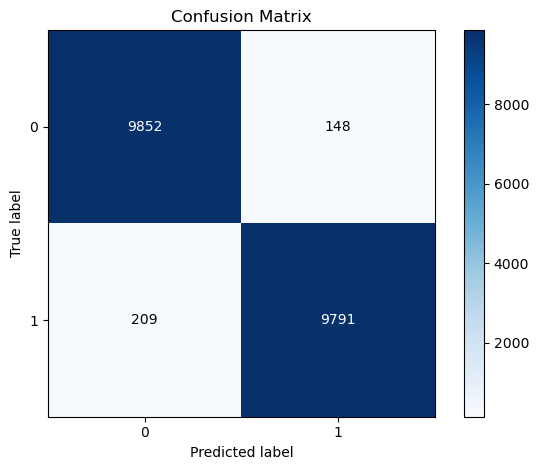

In [26]:
num_classes = 1
loss_fn = nn.BCEWithLogitsLoss()

for checkpoint_path, model_name in zip(checkpoint_paths, model_names):
    # Load the model using the function
    loaded_model = load_model(checkpoint_path, num_classes, device)
    loaded_model = loaded_model.to(device)
    # Evaluate the loaded model on the test set
    print(checkpoint_path)
    evaluate_model(model_name, loaded_model, dataloaders['test'], loss_fn)